#Part III. Model Evaluation on the whole slides

In [ ]:
import importlib, warnings
exist_openslide = importlib.util.find_spec('openslide')
if not exist_openslide:
    !apt-get install openslide-tools
    !pip install openslide-python
else:
    warnings.warn('Openslide already installed.')

In [2]:
from openslide import open_slide
from matplotlib import pyplot as plt
import numpy as np
import os
from google.colab import drive
from skimage.color import rgb2gray
np.random.seed(0)
import tensorflow as tf
from PIL import Image as Img
import progressbar
import pathlib

In [3]:
drive.mount('/content/drive', force_remount=True)
ROOT = '/content/drive/My Drive/applied_deep_learning/project/'

Mounted at /content/drive


In [4]:
IMG_SIZE = 256

**1. Read the test data to be evaluated**

In [5]:
class ReadTestData(object):
    def __init__(self, level):
        self.level = level
        self.slide = None
        self.mask = None
        self.slide_img = None
        self.mask_img = None

        self.import_and_read_tif()
        self.trainable_data = None
        self.rows = 0
        self.cols = 0

In [6]:
class ReadTestData(ReadTestData):
    def import_and_read_tif(self):
        """
        Import a slides and its corresponding tumor mask
        """
        slide_path = ROOT + 'slides/tumor_078.tif'
        tumor_mask_path = ROOT + 'slides/tumor_078_mask.tif'
        self.slide = open_slide(slide_path)
        self.mask = open_slide(tumor_mask_path)

        width, height = self.slide.level_dimensions[self.level]
        self.slide_img = self.read_single_img(self.slide, x=0, y=0, level=self.level, 
                                              width=width, height=height)
        self.mask_img = self.read_single_img(self.mask, x=0, y=0, level=self.level, 
                                             width=width, height=height)[:,:,0]

        print('Slide and tumor mask successfully imported and read for level {}.'.format(self.level))

In [7]:
class ReadTestData(ReadTestData):    
    def read_single_img(self, slide, x, y, level, width, height, as_float=False):
        """
        Read a region from a single slide
        Return a numpy RBG array
        Input:
            slide_path (str): the path of the whole slide
            x (int): x position at level 0
            y (int): y position at level 0
            level (int): zoom level of the region
            width (int): width of the image at level=level 
            height (int): height of the image at level=level 
        """
        im = slide.read_region((x,y), level, (width, height))
        im = im.convert('RGB') # drop the alpha channel
        if as_float:
            im = np.asarray(im, dtype=np.float32)
        else:
            im = np.asarray(im)
        assert im.shape == (height, width, 3)
        return im

In [8]:
class ReadTestData(ReadTestData):         
    def partial_tif(self):
        """
        Slice from the given level of the whole slide and its corresponding tumor
        mask into parts
        Return a list with 3 sliced slides and 3 sliced masks
        """
        width, height = self.slide.level_dimensions[self.level]
        down_factor = pow(2, self.level)
        self.rows = int(np.ceil(self.slide.level_dimensions[self.level][1] / IMG_SIZE))
        self.cols = int(np.ceil(self.slide.level_dimensions[self.level][0] / IMG_SIZE))
        for i in range(0, self.slide.level_dimensions[self.level][0], IMG_SIZE):
            for j in range(0, self.slide.level_dimensions[self.level][1], IMG_SIZE):
                slide_part = self.read_single_img(self.slide, x=i * down_factor, y=j * down_factor, 
                                                  level=self.level, width=IMG_SIZE, height=IMG_SIZE) 
                mask_part = self.read_single_img(self.mask, x=i * down_factor, y=j * down_factor, 
                                                 level=self.level, width=IMG_SIZE, height=IMG_SIZE)[:,:,0]
                slide_img = Img.fromarray(slide_part, 'RGB')
                mask_img = Img.fromarray(mask_part.astype('uint8'), mode='L')

                slide_part_file = '{}test/slide_parts/level_{}/{}_{}'.format(ROOT, self.level, i // IMG_SIZE, j // IMG_SIZE) ###### output file path for image
                mask_part_file = '{}test/mask_parts/level_{}/{}_{}'.format(ROOT, self.level, i // IMG_SIZE, j // IMG_SIZE) ###### output file path for image

                slide_img.save(slide_part_file, 'JPEG')
                mask_img.save(mask_part_file, 'JPEG')
        print('All partial slides and masks successfully created for level {}.\n'.format(self.level))

In [9]:
class ReadTestData(ReadTestData):
    def decode_slide(self, path):
        """
        Read one slide image from the imput path, decode the image, conver it, 
        and rescale it to [0, 1] scale
        Return a tf.Tensor(float32)
        Input:
            path (tf.Tensor(string)): the path of slide image
        """
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image / 255.0

In [10]:
class ReadTestData(ReadTestData):
    def decode_mask(self, path):
        """
        Read one mask image from the imput path, decode the image, conver it, 
        and rescale it to [0, 1] scale
        Return a tf.Tensor(uint32)
        Input:
            path (tf.Tensor(string)): the path of mask image
        """
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.image.convert_image_dtype(image, tf.uint8)
        return image // 255

In [11]:
class ReadTestData(ReadTestData):         
    def convert2trainable(self):
        """
        Convert the sliced slides and tumor masks parts into trainable fromat
        and zip them together to enable them being inserted into our model
        """
        slides_folder = ROOT + 'test/slide_parts/level_{}'.format(self.level)
        masks_folder = ROOT + 'test/mask_parts/level_{}'.format(self.level)

        all_files = os.listdir(slides_folder)
        all_files.sort(key=lambda x: int(x.split('_')[0]))

        all_slides_paths = [os.path.join(slides_folder, file_name) for file_name in all_files]
        all_masks_paths = [os.path.join(masks_folder, file_name) for file_name in all_files]
        
        all_slides_paths = tf.data.Dataset.from_tensor_slices(all_slides_paths)
        all_masks_paths = tf.data.Dataset.from_tensor_slices(all_masks_paths)

        trainable_slides = all_slides_paths.map(self.decode_slide)
        trainable_masks = all_masks_paths.map(self.decode_mask)
        self.trainable_data = tf.data.Dataset.zip((trainable_slides, trainable_masks))

**2. Run the whole read-in data process**

Now all the relevant member functions in the ReadTestData class have been defined and we are able to run the whole data read-in process for all the 3 layers as below.

In [13]:
read_3 = ReadTestData(level=3)
read_3.partial_tif()
read_3.convert2trainable()

Slide and tumor mask successfully imported and read for level 3.
All partial slides and masks successfully created for level 3.



In [14]:
read_4 = ReadTestData(level=4)
read_4.partial_tif()
read_4.convert2trainable()

Slide and tumor mask successfully imported and read for level 4.
All partial slides and masks successfully created for level 4.



In [33]:
read_5 = ReadTestData(level=5)
read_5.partial_tif()
read_5.convert2trainable()

Slide and tumor mask successfully imported and read for level 5.
All partial slides and masks successfully created for level 5.



**3. Load and evaluate our model**

In [16]:
class Testing(object):
    def __init__(self, rows, cols, level):
        self.rows = rows
        self.cols = cols
        self.level = level
        self.model = tf.keras.models.load_model('{}UNet_level_{}.h5'.format(ROOT, self.level))
        
        self.pred_masks = []
        self.whole_mask = np.zeros(shape=(IMG_SIZE * self.rows, IMG_SIZE * self.cols), dtype=np.float32)

In [17]:
class Testing(Testing):
    def predict(self, data):
        """
        Predict the possible mask of the inserting test data
        Input:
            data (tf.Tensor): test data consisting of a small part in the zipped data
        """
        for slide, _ in data:
            pred = self.model.predict(slide[tf.newaxis,...])
            self.pred_masks.append(self.create_mask(pred)[:,:,0])

In [18]:
class Testing(Testing):    
    def create_mask(self, pred_mask):
        """
        Create the mask pixels in the predicted mask
        Return a np.array()
        Input:
            pred_mask (tf.Tensor): predicted mask obtained with the model
        """
        pred_mask = pred_mask[0]
        mask = np.where(pred_mask > 0.5, 1, 0)
        return mask

In [19]:
class Testing(Testing):
    def join_masks(self):
        """
        Combined the predicted partial masks into a whole predicted tumor mask
        """
        count = 0
        for i in range(self.cols):
            for j in range(self.rows):
                self.whole_mask[j*IMG_SIZE : (j+1)*IMG_SIZE, 
                                i*IMG_SIZE : (i+1)*IMG_SIZE] = self.pred_masks[count] / 255.0
                count += 1

In [20]:
class Testing(Testing):    
    def compare_result(self, display_list):
        """
        Plot the original slide image, true tumor mask image and the predicted 
        tumor mask image for comparison
        Input: 
            display_list (List[np.array]): slide image, true mask and predicted mask
        """
        plt.figure(figsize=(30, 30))
        title = ['Input Image', 'True Mask', 'Predicted Mask']
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i + 1)
            plt.title(title[i], fontsize=16)
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

**4. Run the whole model evaluating proccess**

Now all the relevant member functions in the ReadTestData class have been defined and we are able to run the whole data read-in process for all the 3 layers as below.

In [34]:
test_3 = Testing(rows=read_3.rows, cols=read_3.cols, level=read_3.level)
test_4 = Testing(rows=read_4.rows, cols=read_4.cols, level=read_4.level)
test_5 = Testing(rows=read_5.rows, cols=read_5.cols, level=read_5.level)

Predict tumors, generate tumor masks and combine into a whole mask image.

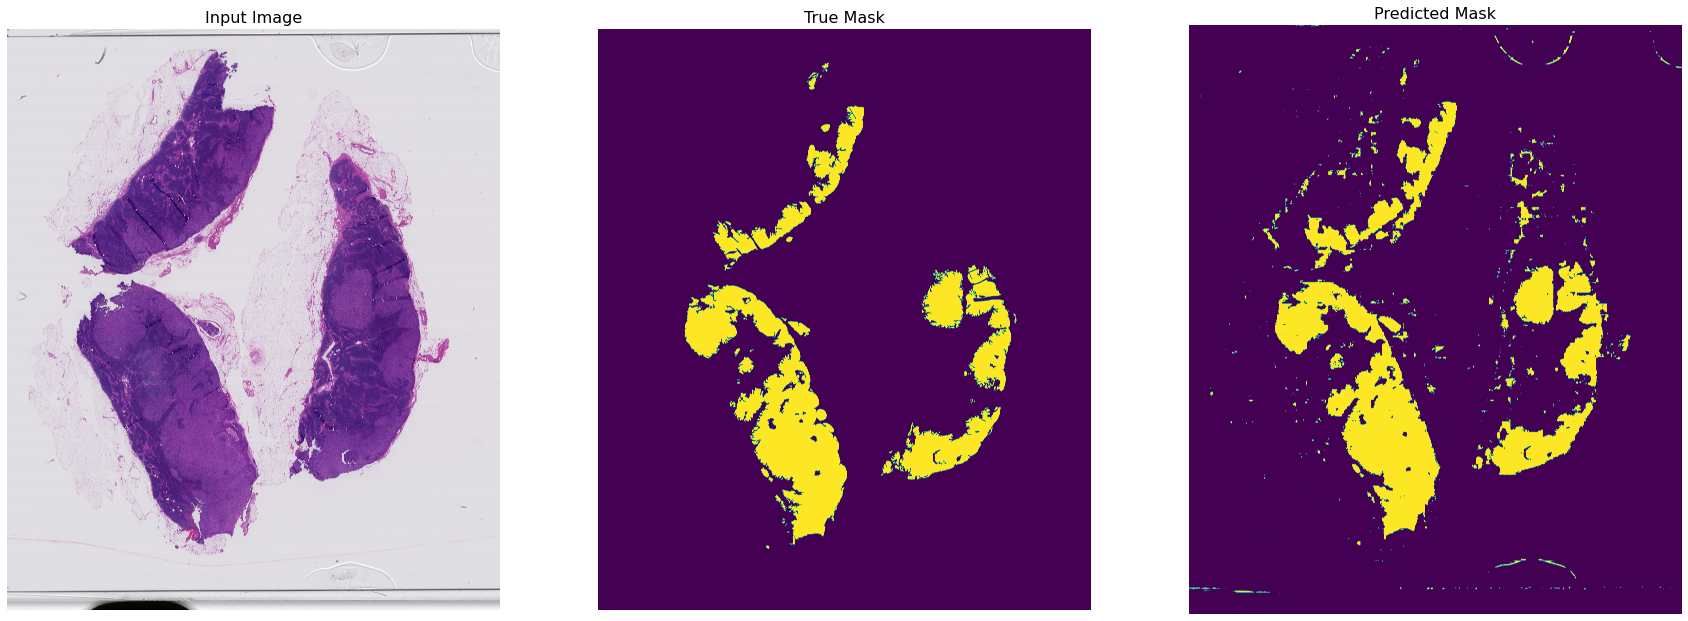

In [22]:
test_3.predict(read_3.trainable_data)
test_3.join_masks()
test_3.compare_result([read_3.slide_img, read_3.mask_img, test_3.whole_mask])

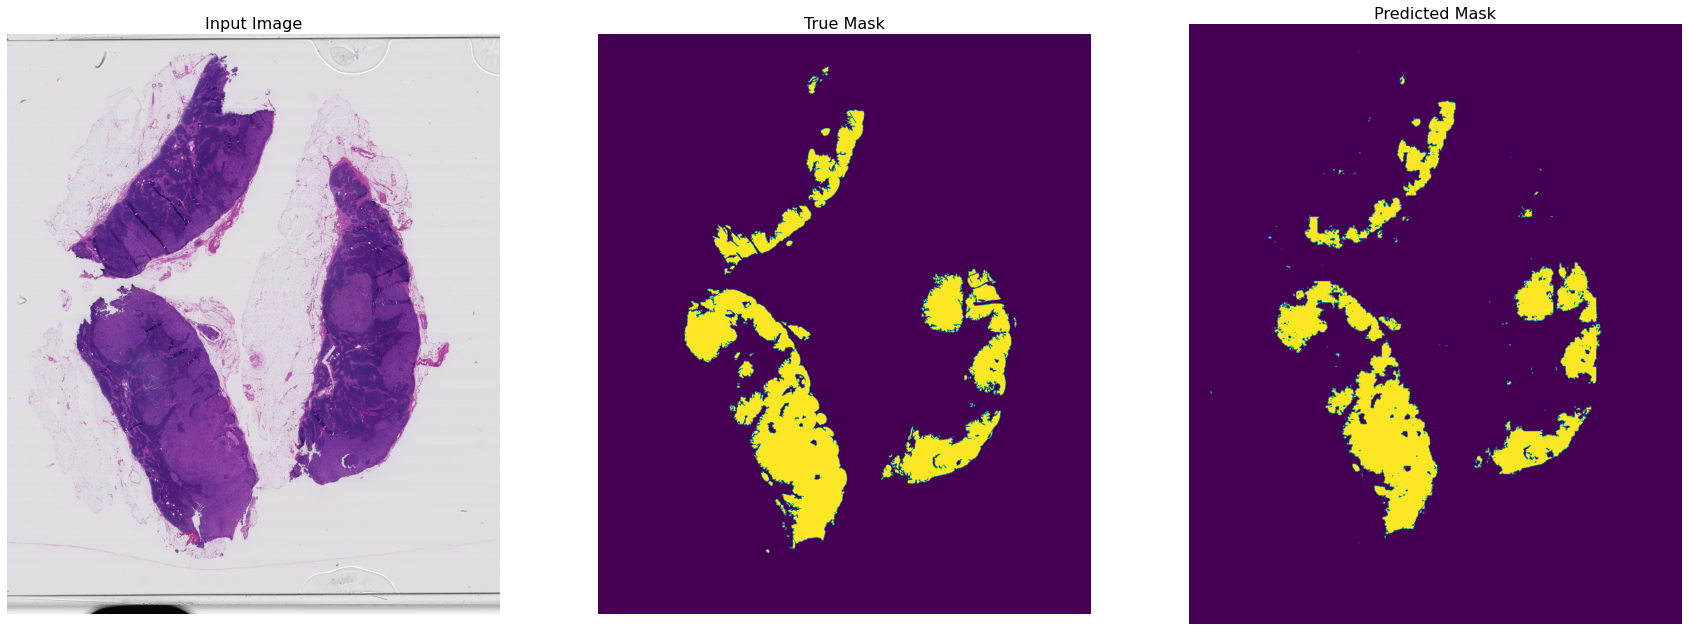

In [23]:
test_4.predict(read_4.trainable_data)
test_4.join_masks()
test_4.compare_result([read_4.slide_img, read_4.mask_img, test_4.whole_mask])

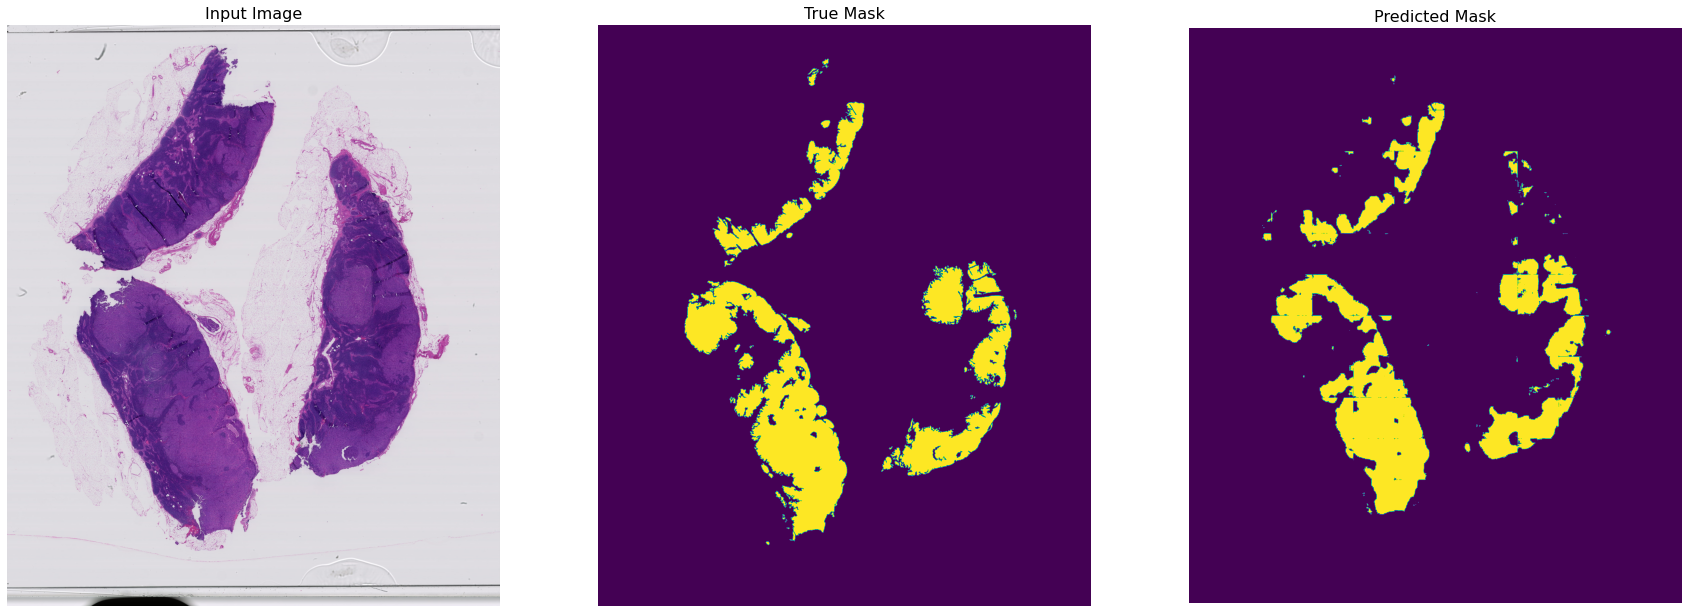

In [35]:
test_5.predict(read_5.trainable_data)
test_5.join_masks()
test_5.compare_result([read_5.slide_img, read_5.mask_img, test_5.whole_mask])

Unexpectedly, the result of level 3 is worse than than of level 4 and level 5. This is possiblly because the sliced size we used is equal in the e layers, while the actual whole slide image size in the 3 layers are different. Thus each slice in the 3 layers contains different amount of information of the whole slide, with slice of level 3 has the smallest amount of information. And when we combine the results of all slices into a whole mask, it is more likely for those less representative slices to have error. Now we combine the predict result for 3 layers and generate a the final result by calculating the average value.

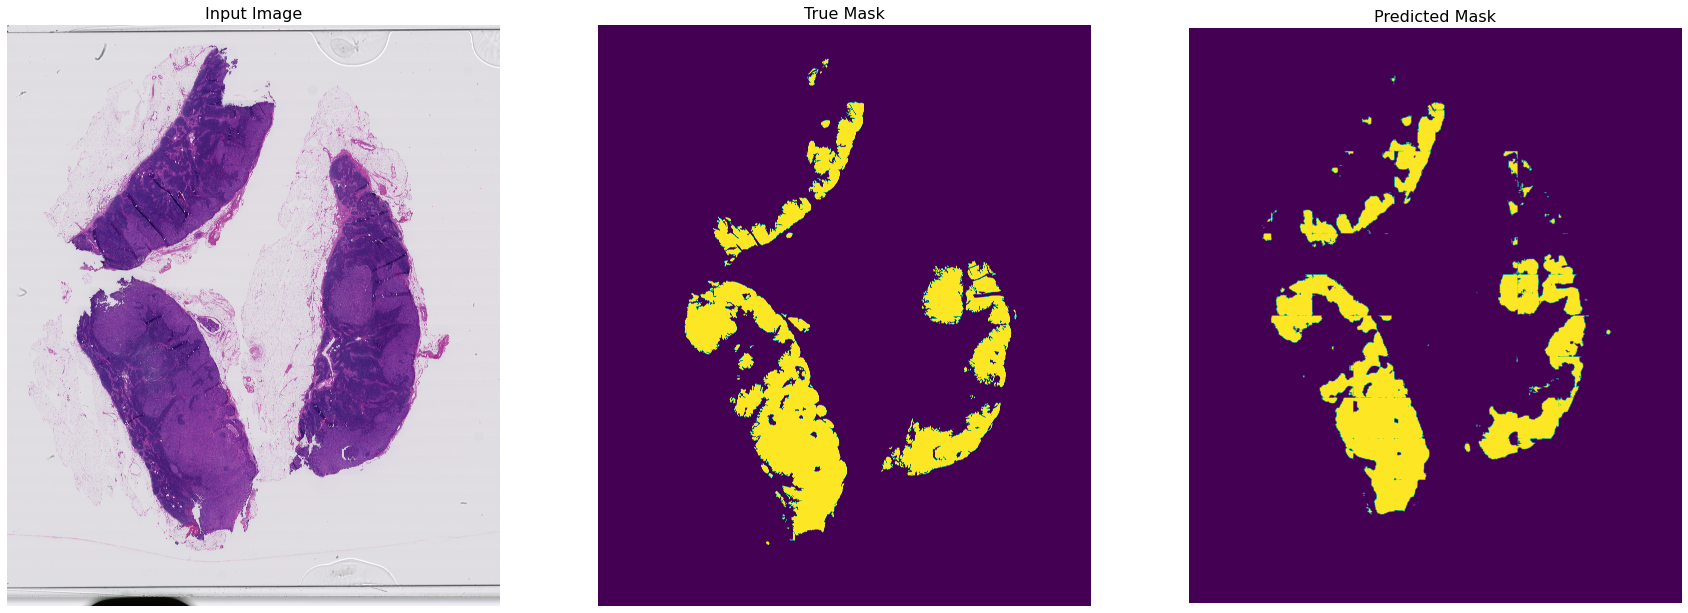

In [36]:
min_shape = np.shape(test_5.whole_mask)
final_result = (np.resize(test_3.whole_mask, min_shape) + np.resize(test_4.whole_mask, min_shape) + test_5.whole_mask) / 3
test_3.compare_result([read_3.slide_img, read_3.mask_img, final_result])

## Conclusion and future expectations

In conclusion, we precisely predicted the location and mophology of the tumor given a whole multi-level slide of lymph node cells. However, we did have a problem when we tried to classify each of the slide parts we sliced into 2 classes, even if this is a easier task to do than predicting the location and morphology. The validation accuracy always remains at around 50% with training loss decreasing. We tried different CNN models, utilizing several regularizing methods, with none of them worked. Now we wonder maybe our data was over-augmented which lead to under-fitting, and we are considering sticking to our current U-Net models which are already trained, freezing their weights and add several dense layers to predict the labels. We will continue on this thought after we submit the project.

Also, there can also be improvement for our whole project architechture. During our training and evaluating proecss, we insert the training data for each of the level 3, 4, 5 and get 3 different models. And then we apply the original slide into the 3 models and combine their 3 predicted tumor masks together as the final result. In our future revising, we could combine the training data before inserting into U-Net and get 1 model for implementation as shown in the figure below.

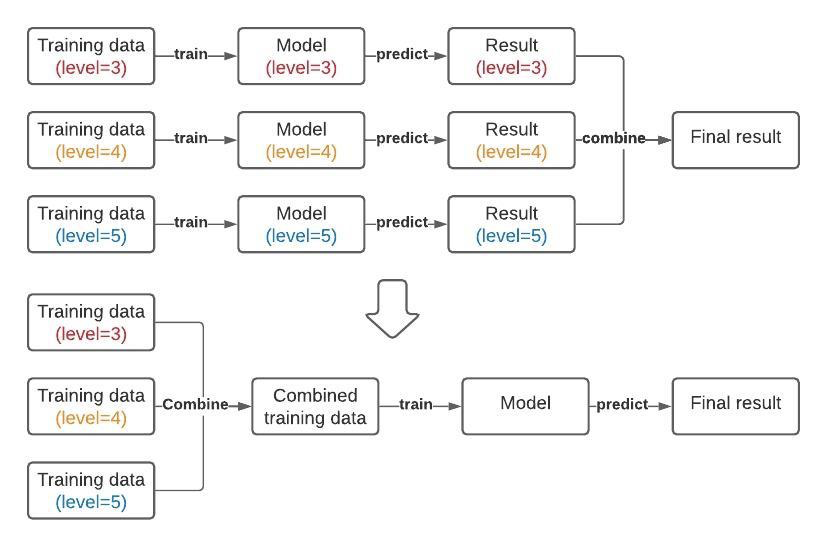